## Key Points for N-gram Language Model

### Install packages

In [1]:
!pip3 install -U pip
!pip3 install -U dill
!pip3 install nltk

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/15/aa/3f4c7bcee2057a76562a5b33ecbd199be08cdb4443a02e26bd2c3cf6fc39/pip-23.3.2-py3-none-any.whl.metadata
Using cached pip-23.3.2-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [2]:
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import pad_sequence
from nltk.lm.preprocessing import pad_both_ends
from nltk.util import everygrams
from nltk.lm.preprocessing import padded_everygram_pipeline

### Preprocessing

##### Tokenizer

In [3]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize
    # Testing whether it works.
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

##### ::Ngrams & Padding

we can use ***pad_both_ends*** to replace the long code in ***pad_sequence***



```
texts = [['我','愛','你','。'],['我們','去','公園','運動','!']]
```


**< pad_sequence >**
```
padded_sent = list(pad_sequence(texts[1], pad_left=True, left_pad_symbol="<s>" pad_right=True, right_pad_symbol="</s>", n=3))
list(ngrams(padded_sent, n=4))
```
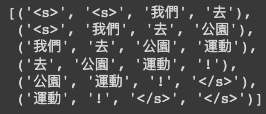

**pad_both_ends**

```
# without ngram
list(pad_both_ends(texts[1], n=4))

# with ngram
list(ngrams(pad_both_ends(texts[1], n=4), n=5))
```
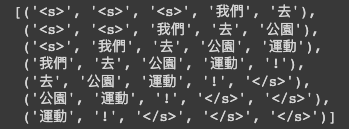




##### ::Everygrams

to produce unigrams, bigrams, and trigrams all at once for training a model
```
from nltk.util import everygrams
padded_allgrams = list(pad_both_ends(texts[0], n=3))
list(everygrams(padded_allgrams, max_len=3))
```
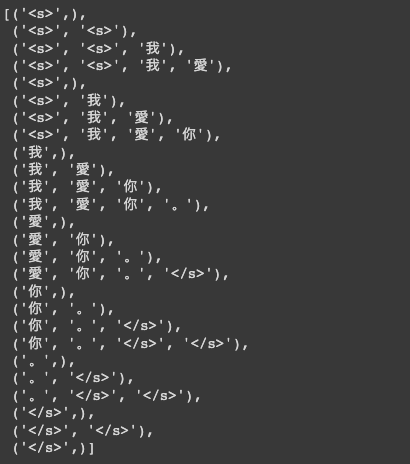

##### ::Flatten wordlist

flatten the padded sentences
(to create a wordlist of *known words* as preparation for training)
```
from nltk.lm.preprocessing import flatten
list(flatten(pad_both_ends(sent, n=3) for sent in texts))
```
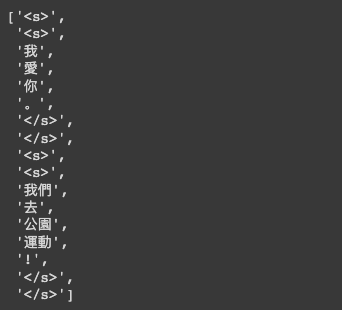

#### Padding + Everygram + Flatten

In [5]:
texts = [['我','愛','你','。'],['我們','去','公園','運動','!']]

In [6]:
from nltk.lm.preprocessing import padded_everygram_pipeline

train_pad_ngrams, flat_vocab = padded_everygram_pipeline(3, texts)
list(flat_vocab)

['<s>',
 '<s>',
 '我',
 '愛',
 '你',
 '。',
 '</s>',
 '</s>',
 '<s>',
 '<s>',
 '我們',
 '去',
 '公園',
 '運動',
 '!',
 '</s>',
 '</s>']

In [7]:
for pad_ngram in train_pad_ngrams:
  print(list(pad_ngram))

[('<s>',), ('<s>', '<s>'), ('<s>', '<s>', '我'), ('<s>',), ('<s>', '我'), ('<s>', '我', '愛'), ('我',), ('我', '愛'), ('我', '愛', '你'), ('愛',), ('愛', '你'), ('愛', '你', '。'), ('你',), ('你', '。'), ('你', '。', '</s>'), ('。',), ('。', '</s>'), ('。', '</s>', '</s>'), ('</s>',), ('</s>', '</s>'), ('</s>',)]
[('<s>',), ('<s>', '<s>'), ('<s>', '<s>', '我們'), ('<s>',), ('<s>', '我們'), ('<s>', '我們', '去'), ('我們',), ('我們', '去'), ('我們', '去', '公園'), ('去',), ('去', '公園'), ('去', '公園', '運動'), ('公園',), ('公園', '運動'), ('公園', '運動', '!'), ('運動',), ('運動', '!'), ('運動', '!', '</s>'), ('!',), ('!', '</s>'), ('!', '</s>', '</s>'), ('</s>',), ('</s>', '</s>'), ('</s>',)]


### Train a model

(MLE) Maximum Likelihood Estimation
<br>[Maximum Likelihood, clearly explained!!!](https://www.youtube.com/watch?v=XepXtl9YKwc)<br>
"Likelihood" refers to situation where you try to find the optimal value for the mean or standard deviation of a distribution give a bunch of observed measurements.



In [8]:
from nltk.lm import MLE

n = 3
model = MLE(n)    # initialize a model
model.fit(train_pad_ngrams, flat_vocab)   # train a model

## Whole Process

### Input & Tokenize data

the tokenizer function defined above

In [9]:
import os
import requests
import io #codecs


# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with io.open('language-never-random.txt', encoding='utf8') as fin:
        text = fin.read()
else:
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with io.open('language-never-random.txt', 'w', encoding='utf8') as fout:
        fout.write(text)

# Tokenize the text.
tokenized_text = [list(map(str.lower, word_tokenize(sent))) for sent in sent_tokenize(text)]

In [20]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

### Train model

In [10]:
from nltk.lm import MLE
n = 3
train_pad_ngrams, flat_vocab = padded_everygram_pipeline(n, tokenized_text)

model = MLE(n)    # initialize a model
model.fit(train_pad_ngrams, flat_vocab)

list(model.vocab)  # vocab used for training

['<s>',
 'language',
 'is',
 'never',
 ',',
 'ever',
 'random',
 'adam',
 'kilgarriff',
 'abstract',
 'users',
 'choose',
 'words',
 'randomly',
 'and',
 'essentially',
 'non-random',
 '.',
 '</s>',
 'statistical',
 'hypothesis',
 'testing',
 'uses',
 'a',
 'null',
 'which',
 'posits',
 'randomness',
 'hence',
 'when',
 'we',
 'look',
 'at',
 'linguistic',
 'phenomena',
 'in',
 'cor-',
 'pora',
 'the',
 'will',
 'be',
 'true',
 'moreover',
 'where',
 'there',
 'enough',
 'data',
 'shall',
 '(',
 'almost',
 ')',
 'always',
 'able',
 'to',
 'establish',
 'that',
 'it',
 'not',
 'corpus',
 'studies',
 'frequently',
 'do',
 'have',
 'so',
 'fact',
 'rela-',
 'tion',
 'between',
 'two',
 'demonstrably',
 'does',
 'sup-',
 'port',
 'inference',
 'arbitrary',
 'present',
 'experimental',
 'evidence',
 'of',
 'how',
 'associations',
 'word',
 'frequencies',
 'corpora',
 'are',
 'systematically',
 'review',
 'literature',
 'test-',
 'ing',
 'has',
 'been',
 'used',
 'show',
 'often',
 'led',
 '

In [11]:
train_pad_ngrams

<generator object padded_everygram_pipeline.<locals>.<genexpr> at 0x10c1c9540>

In [12]:
print(model.vocab.lookup(tokenized_text[0]))

('language', 'is', 'never', ',', 'ever', ',', 'ever', ',', 'random', 'adam', 'kilgarriff', 'abstract', 'language', 'users', 'never', 'choose', 'words', 'randomly', ',', 'and', 'language', 'is', 'essentially', 'non-random', '.')


#### Utalizing the Trained Model

Calculate number of certain ngrams

In [13]:
print(model.counts['language'])  #  i.e. Count('language')
print(model.counts[['language']]['is'])  # i.e. Count('is'|'language')
print(model.counts[['language', 'is']]['never']) # i.e. Count('never'|'language is')

25
11
7


Calculate relative frequency of certain ngrams


In [14]:
print(model.score('language')) # P('language')
print(model.score('is', 'language'.split()))  # P('is'|'language')
print(model.score('never', 'language is'.split()))  # P('never'|'language is')
print(model.score("lah"))
print(model.score("<UNK>"))

0.003916040100250626
0.44
0.6363636363636364
0.0
0.0


Transform the score into log value.


In [15]:
model.logscore("never", "language is".split())

-0.6520766965796932

Evaluate model's cross-entropy and perplexity about sequence of n-gram

In [16]:
test = [("language", "is"), ("never", "used")]
print(model.entropy(test)) #???
print(model.perplexity(test))

inf
inf


#### Smooothing

Different smoothing approaches > nltk.lm.models >
[src1](https://github.com/nltk/nltk/blob/develop/nltk/lm/models.py)
[src2](https://docs.huihoo.com/nltk/3.4/_modules/nltk/lm/models.html)
<br>
- Lidstone: Provides Lidstone-smoothed scores.
- Laplace: Implements Laplace (add one) smoothing.
- InterpolatedLanguageModel: Logic common to all interpolated language models (Chen & Goodman 1995).
- WittenBellInterpolated: Interpolated version of Witten-Bell smoothing.
-  KneserNeyInterpolate: Interpolated version of Kneser Ney smoothing.

In [17]:
from nltk.lm import Lidstone
from nltk.util import ngrams
from nltk.lm import NgramCounter
from nltk.lm import KneserNeyInterpolated

train_pad_ngrams, flat_vocab = padded_everygram_pipeline(n, tokenized_text)

n = 3
LS_model = Lidstone(0.2, n, flat_vocab)
#LS_model.fit(train_pad_ngrams)
print(flat_vocab)
KN_model = KneserNeyInterpolated(n)
KN_model.fit(train_pad_ngrams, flat_vocab)
print(list(KN_model.vocab))

['<s>', 'language', 'is', 'never', ',', 'ever', 'random', 'adam', 'kilgarriff', 'abstract', 'users', 'choose', 'words', 'randomly', 'and', 'essentially', 'non-random', '.', '</s>', 'statistical', 'hypothesis', 'testing', 'uses', 'a', 'null', 'which', 'posits', 'randomness', 'hence', 'when', 'we', 'look', 'at', 'linguistic', 'phenomena', 'in', 'cor-', 'pora', 'the', 'will', 'be', 'true', 'moreover', 'where', 'there', 'enough', 'data', 'shall', '(', 'almost', ')', 'always', 'able', 'to', 'establish', 'that', 'it', 'not', 'corpus', 'studies', 'frequently', 'do', 'have', 'so', 'fact', 'rela-', 'tion', 'between', 'two', 'demonstrably', 'does', 'sup-', 'port', 'inference', 'arbitrary', 'present', 'experimental', 'evidence', 'of', 'how', 'associations', 'word', 'frequencies', 'corpora', 'are', 'systematically', 'review', 'literature', 'test-', 'ing', 'has', 'been', 'used', 'show', 'often', 'led', 'unhelpful', 'or', 'mislead-', 'results.', 'keywords', ':', '쎲쎲쎲', '1', 'introduction', 'any', 'm

/var/folders/sb/4s3tlj4134gd2dqpc34thbyr0000gn/T/ipykernel_85219/2324691363.py:9: UserWarning: The `vocabulary` argument passed to 'Lidstone' must be an instance of `nltk.lm.Vocabulary`.
  LS_model = Lidstone(0.2, n, flat_vocab)


In [21]:
#KN_model.generate(20, random_seed=17)
generate_sent(KN_model, 20)

'of a phenomenon gen- erally gives us reason to expect words to behave as if they are all marked as'

### Generate Texts with the Trained Model

In [22]:
#generate a 20-word sentense
print(model.generate(20, random_seed=7))

['ate', 'inferences', 'are', 'drawn.', '2', '.', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>']


We can further clean the above generated text to make the output more "human-readable".

In [23]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [24]:
generate_sent(model, 20, random_seed=7)

'ate inferences are drawn. 2.'

In [25]:
generate_sent(KN_model, 20, random_seed = 17)

'is the weak link in the minority and is not random, does not support the inference that it is'

### Save the trained model

The model saved into a `pickle` file can be used directly anytime without needing to train the whole dataset from scratch.

In [ ]:
import dill as pickle

with open('kilgariff_ngram_model.pkl', 'wb') as fout:
    pickle.dump(model, fout)

### Load the saved model

In [ ]:
with open('kilgariff_ngram_model.pkl', 'rb') as fin:
    model_loaded = pickle.load(fin)

generate_sent(model_loaded, 20, random_seed=42)

## Practice

### Load data

In [1]:
book = open("/Users/ansleyhung/Desktop/笑傲江湖1-3.txt").read()

In [2]:
book = book.split("\n")

In [5]:
type(book[1])
book[1]

''

### Tokenize texts

In [6]:
!pip3 install ckiptagger

You should consider upgrading via the '/Users/ansleyhung/python/python39/python39venv/bin/python3 -m pip install --upgrade pip' command.


In [9]:
from ckiptagger import data_utils
data_utils.download_data_gdown("./")

Downloading...
From (uriginal): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771
From (redirected): https://drive.google.com/uc?id=1efHsY16pxK0lBD2gYCgCTnv1Swstq771&confirm=t&uuid=4f9097c1-c36e-4407-a1a9-31bbf9ea1dd7
To: /Users/ansleyhung/python/python39/data.zip
100%|████████████████████████████████████████████████████████████████| 1.88G/1.88G [00:45<00:00, 40.9MB/s]


In [10]:
from ckiptagger import WS
ws = WS("./data")

/Users/ansleyhung/python/python39/python39venv/lib/python3.9/site-packages/ckiptagger/model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
2023-12-17 16:02:00.114811: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


In [11]:
tokenized_book = ws(book)

In [12]:
tokenized_book

[['第一', '章', '\u3000', '滅門'],
 [],
 ['\u3000\u3000',
  '和',
  '風熏柳',
  '，',
  '花香',
  '醉人',
  '，',
  '正',
  '是',
  '南國',
  '春光',
  '漫爛',
  '季節',
  '。',
  '福建省',
  '福州府',
  '西門大街',
  '，',
  '青石板路',
  '筆直',
  '的',
  '伸展',
  '出去',
  '，',
  '直通',
  '西門',
  '。',
  '一',
  '座',
  '建构',
  '宏偉',
  '的',
  '宅第',
  '之前',
  '，',
  '左右',
  '兩',
  '座',
  '石壇',
  '中',
  '各',
  '豎',
  '一',
  '根',
  '兩',
  '丈',
  '來',
  '高',
  '的',
  '旗杆',
  '，',
  '杆頂',
  '飄揚',
  '青旗',
  '。',
  '右首',
  '旗上',
  '黃色',
  '絲線',
  '繡',
  '著',
  '一',
  '頭',
  '張牙舞爪',
  '、',
  '神態',
  '威猛',
  '的',
  '雄獅',
  '，',
  '旗子',
  '隨',
  '風',
  '招展',
  '，',
  '顯得',
  '雄獅',
  '更',
  '奕奕若生',
  '。',
  '雄獅',
  '頭頂',
  '有',
  '一',
  '對',
  '黑',
  '絲線繡',
  '的',
  '蝙蝠',
  '展翅',
  '飛翔',
  '。',
  '左首',
  '旗',
  '上',
  '繡',
  '著',
  '“',
  '福威',
  '鏢局',
  '”',
  '四',
  '個',
  '黑字',
  '，',
  '銀鉤',
  '鐵划',
  '，',
  '剛勁',
  '非凡',
  '。',
  '大宅',
  '朱漆',
  '大門',
  '，',
  '門',
  '上',
  '茶杯',
  '大小',
  '的',
  '銅釘',
  '閃閃發光',
  '，',
  '門頂',
  '匾額',
  '

### Padding + Everygram + Flatten

In [15]:
from nltk.lm.preprocessing import padded_everygram_pipeline
# run it everytime you try to train a new model
train_pad_ngrams, flat_vocab = padded_everygram_pipeline(3, tokenized_book)

### Train and Smooth model

In [16]:
from nltk.lm import KneserNeyInterpolated
n = 3
KNI_model = KneserNeyInterpolated(n)
KNI_model.fit(train_pad_ngrams, flat_vocab)

In [17]:
from nltk.lm import WittenBellInterpolated
n = 3
WTB_model = WittenBellInterpolated(n)
WTB_model.fit(train_pad_ngrams, flat_vocab)

In [18]:
from nltk.lm import Laplace
n = 3
Add1_model = Laplace(n)
Add1_model.fit(train_pad_ngrams, flat_vocab)

### Generate Texts

raw code <br>

> < model >.generate()



In [19]:
KNI_model.generate(20, random_seed=21)

['件',
 '暗器',
 '激射',
 '而',
 '下',
 '，',
 '那',
 '四川',
 '漢子',
 '、',
 '史鏢頭',
 '又',
 '如何',
 '動',
 '起',
 '手',
 '來',
 '。',
 '隔',
 '著']

More human-like text generation

In [20]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [21]:
generate_sent(KNI_model, 20, random_seed = 21)

'件 暗器 激射 而 下 ， 那 四川 漢子 、 史鏢頭 又 如何 動 起 手 來 。 隔 著'

In [ ]:
generate_sent(WTB_model, 20, random_seed = 21)

In [ ]:
generate_sent(Add1_model, 20, random_seed = 21)